<a href="https://colab.research.google.com/github/Trishti-s/Probability_Density_Function/blob/main/PDF_using_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install scipy


In [2]:
!unzip "/content/data.csv (1).zip"

Archive:  /content/data.csv (1).zip
  inflating: data.csv                


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv("/content/data.csv", encoding='latin1')
df.head()

/tmp/ipython-input-2066522828.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/data.csv", encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [7]:
x=df["no2"].dropna().values

In [8]:
r=102313056
a_r=0.5*(r%7)
b_r=0.3*((r%5)+1)
print(a_r,b_r)

3.0 0.6


In [9]:
z=x+a_r*np.sin(b_r*x)

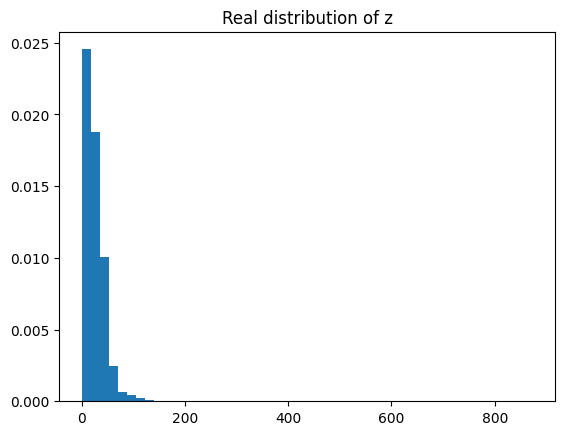

In [11]:
plt.hist(z,bins=50,density=True)
plt.title("Real distribution of z")
plt.show()

In [12]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [13]:
criterion=nn.BCELoss()

G=Generator()
D=Discriminator()

opt_G=torch.optim.Adam(G.parameters(), lr=0.001)
opt_D=torch.optim.Adam(D.parameters(), lr=0.001)

real_data=torch.tensor(z, dtype=torch.float32).view(-1,1)

epochs=3000
batch_size=64

for epoch in range(epochs):

    idx = np.random.randint(0, len(real_data), batch_size)
    real_batch = real_data[idx]

    noise = torch.randn(batch_size, 1)
    fake_batch = G(noise)

    D_real = D(real_batch)
    D_fake = D(fake_batch.detach())

    loss_D = criterion(D_real, torch.ones_like(D_real)) + \
             criterion(D_fake, torch.zeros_like(D_fake))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    noise = torch.randn(batch_size, 1)
    fake_batch = G(noise)
    D_fake = D(fake_batch)

    loss_G = criterion(D_fake, torch.ones_like(D_fake))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 500 == 0:
        print(epoch, loss_D.item(), loss_G.item())



0 4.656208515167236 0.7241685390472412
500 1.2824206352233887 0.8374459147453308
1000 1.3634018898010254 0.7514552474021912
1500 1.403336524963379 0.8310843706130981
2000 1.3727607727050781 0.7155662178993225
2500 1.3981045484542847 0.6406924724578857


In [14]:
noise = torch.randn(10000, 1)
generated_samples = G(noise).detach().numpy()


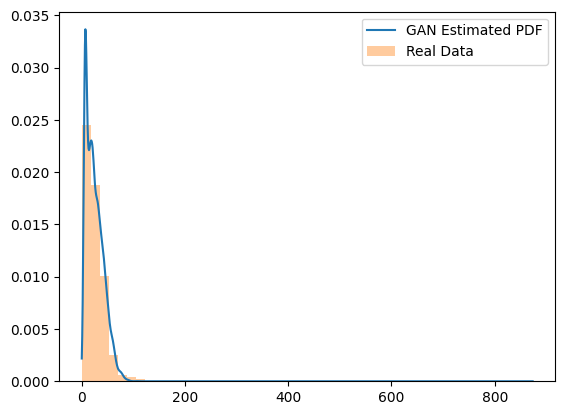

In [15]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(generated_samples.flatten())

x_range = np.linspace(min(z), max(z), 1000)
pdf_est = kde(x_range)

plt.plot(x_range, pdf_est, label="GAN Estimated PDF")
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real Data")
plt.legend()
plt.show()
